<a href="https://colab.research.google.com/github/Ramprabu95/RNN-based-Text-Classification-in-presence-of-noise/blob/main/rcnn_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda')
class RCNN(nn.Module):
    """
    Recurrent Convolutional Neural Networks for Text Classification (2015)
    """
    def __init__(self, vocab_size, embedding_dim, hidden_size, hidden_size_linear, class_num, dropout):
        super(RCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True, bidirectional=True, dropout=dropout)
        self.W = nn.Linear(embedding_dim + 2*hidden_size, hidden_size_linear)
        self.tanh = nn.Tanh()
        self.fc = nn.Linear(hidden_size_linear, class_num)

    def forward(self, x):
        # x = |bs, seq_len|
        x_emb = self.embedding(x)
        # x_emb = |bs, seq_len, embedding_dim|
        output, _ = self.lstm(x_emb)
        # output = |bs, seq_len, 2*hidden_size|
        output = torch.cat([output, x_emb], 2)
        # output = |bs, seq_len, embedding_dim + 2*hidden_size|
        output = self.tanh(self.W(output)).transpose(1, 2)
        # output = |bs, seq_len, hidden_size_linear| -> |bs, hidden_size_linear, seq_len|
        output = F.max_pool1d(output, output.size(2)).squeeze(2)
        # output = |bs, hidden_size_linear|
        output = self.fc(output)
        # output = |bs, class_num|
        return output

In [88]:

import torch
from torch.utils.data import Dataset


class CustomTextDataset(Dataset):
    def __init__(self, texts, labels, dictionary):
        # Unknown Token is index 1 (<UNK>)
        self.x = [[dictionary.get(token, 1) for token in token_list] for token_list in texts]
        self.y = labels

    def __len__(self):
        """Return the data length"""
        return len(self.x)

    def __getitem__(self, idx):
        """Return one item on the index"""
        return self.x[idx], self.y[idx]


def collate_fn(data, max_len, pad_idx=0):
    """Padding"""
    texts, labels = zip(*data)
    texts = [s + [pad_idx] * (max_len - len(s)) if len(s) < max_len else s[:max_len] for s in texts]
    return torch.LongTensor(texts), torch.LongTensor(labels)

In [89]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
nltk.download('punkt')


def read_file(file_path):
    """
    Read function for AG NEWS Dataset
    """
    data = pd.read_csv(file_path, names=["class", "title", "description"])
    texts = list(data['title'].values + ' ' + data['description'].values)
    texts = [word_tokenize(preprocess_text(sentence)) for sentence in texts]
    labels = [label-1 for label in list(data['class'].values)]  # label : 1~4  -> label : 0~3
    return texts, labels


def preprocess_text(string):
    """
    reference : https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = string.lower()
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip()


def metrics(dataloader, losses, correct, y_hats, targets):
    avg_loss = losses / len(dataloader)
    accuracy = correct / len(dataloader.dataset) * 100
    precision = precision_score(targets, y_hats, average='macro')
    recall = recall_score(targets, y_hats, average='macro')
    f1 = f1_score(targets, y_hats, average='macro')
    cm = confusion_matrix(targets, y_hats)
    return avg_loss, accuracy, precision, recall, f1, cm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [90]:

import os
import logging
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt



def train(model, optimizer1,optimizer2, train_dataloader, valid_dataloader, epochs):
    best_f1 = 0
    loss_val=[]
    step_num=[]
    count = 1
    print('Start Training!')
    for epoch in range(1, epochs+1):
        model.train()
        for step, (x, y) in enumerate(train_dataloader):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = F.cross_entropy(pred, y)
            if loss>0.3:
              optimizer1.zero_grad()
              loss.backward()
              optimizer1.step()
            else:
              optimizer2.zero_grad()
              loss.backward()
              optimizer2.step()

            if (step+1) % 200 == 0:
                print(f'|EPOCHS| {epoch:>}/{epochs} |STEP| {step+1:>4}/{len(train_dataloader)} |LOSS| {loss.item():>.4f}')
                loss_val.append(loss.item())
                step_num.append(int(count))
                count += 1
        avg_loss, accuracy, _, _, f1, _ = evaluate(model, valid_dataloader)
        print('-'*50)
        print(f'|* VALID SET *| |VAL LOSS| {avg_loss:>.4f} |ACC| {accuracy:>.4f} |F1| {f1:>.4f}')
        print('-'*50)
        PATH = './best.pth'
        if f1 > best_f1:
            best_f1 = f1
            print(f'Saving best model... F1 score is {best_f1:>.4f}')
            torch.save(model.state_dict(),PATH)
            print('Model saved!')
    plt.plot(step_num,loss_val)
    plt.xlabel("Step Number")
    plt.ylabel("Loss")
    plt.show()


def evaluate(model, valid_dataloader):
    with torch.no_grad():
        model.eval()
        losses, correct = 0, 0
        y_hats, targets = [], []
        for x, y in valid_dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = F.cross_entropy(pred, y)
            losses += loss.item()

            y_hat = torch.max(pred, 1)[1]
            y_hats += y_hat.tolist()
            targets += y.tolist()
            correct += (y_hat == y).sum().item()

    avg_loss, accuracy, precision, recall, f1, cm = metrics(valid_dataloader, losses, correct, y_hats, targets)
    return avg_loss, accuracy, precision, recall, f1, cm



In [91]:
from collections import Counter


def build_dictionary(texts, vocab_size):
    counter = Counter()
    SPECIAL_TOKENS = ['<PAD>', '<UNK>']

    for word in texts:
        counter.update(word)

    words = [word for word, count in counter.most_common(vocab_size - len(SPECIAL_TOKENS))]
    words = SPECIAL_TOKENS + words
    word2idx = {word: idx for idx, word in enumerate(words)}

    return word2idx

In [92]:
from google.colab import drive 

# Mounting google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Start Training!
|EPOCHS| 1/10 |STEP|  200/2500 |LOSS| 1.3361
|EPOCHS| 1/10 |STEP|  400/2500 |LOSS| 1.2545
|EPOCHS| 1/10 |STEP|  600/2500 |LOSS| 1.1278
|EPOCHS| 1/10 |STEP|  800/2500 |LOSS| 1.0954
|EPOCHS| 1/10 |STEP| 1000/2500 |LOSS| 0.8862
|EPOCHS| 1/10 |STEP| 1200/2500 |LOSS| 0.7274
|EPOCHS| 1/10 |STEP| 1400/2500 |LOSS| 0.7839
|EPOCHS| 1/10 |STEP| 1600/2500 |LOSS| 0.7709
|EPOCHS| 1/10 |STEP| 1800/2500 |LOSS| 0.7514
|EPOCHS| 1/10 |STEP| 2000/2500 |LOSS| 0.7382
|EPOCHS| 1/10 |STEP| 2200/2500 |LOSS| 0.6559
|EPOCHS| 1/10 |STEP| 2400/2500 |LOSS| 0.4338
--------------------------------------------------
|* VALID SET *| |VAL LOSS| 0.5663 |ACC| 79.5925 |F1| 0.7951
--------------------------------------------------
Saving best model... F1 score is 0.7951
Model saved!
|EPOCHS| 2/10 |STEP|  200/2500 |LOSS| 0.4491
|EPOCHS| 2/10 |STEP|  400/2500 |LOSS| 0.4396
|EPOCHS| 2/10 |STEP|  600/2500 |LOSS| 0.3534
|EPOCHS| 2/10 |STEP|  800/2500 |LOSS| 0.4579
|EPOCHS| 2/10 |STEP| 1000/2500 |LOSS| 0.5863
|EPO

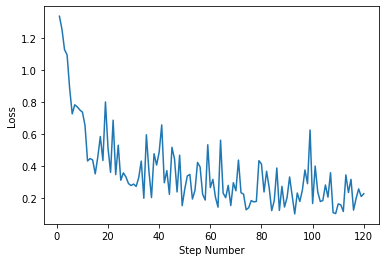

In [93]:
train_file_path = '/content/drive/MyDrive/Colab Notebooks/data_text/train.csv'
import os
import argparse
import logging
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split

model = RCNN(vocab_size=30000,
            embedding_dim=500,
            hidden_size=1024,
            hidden_size_linear=1024,
            class_num=4,
            dropout=0.0).to(device)


train_texts, train_labels = read_file(train_file_path)
word2idx = build_dictionary(train_texts, vocab_size=30000)
full_dataset = CustomTextDataset(train_texts, train_labels, word2idx)
num_train_data = len(full_dataset) - 40000

train_dataset, val_dataset = random_split(full_dataset, [num_train_data, 40000])
train_dataloader = DataLoader(dataset=train_dataset,
                                  collate_fn=lambda x: collate_fn(x, 32),
                                  batch_size=32,
                                  shuffle=True)
valid_dataloader = DataLoader(dataset=val_dataset,
                                  collate_fn=lambda x: collate_fn(x, 32),
                                  batch_size=32,
                                  shuffle=True)

optimizer1 = torch.optim.Adam(model.parameters(), lr=1e-5)
optimizer2 = torch.optim.Adam(model.parameters(), lr=1e-6)
train(model, optimizer1,optimizer2, train_dataloader, valid_dataloader,10)

In [94]:
test_model = RCNN(vocab_size=30000,
            embedding_dim=500,
            hidden_size=1024,
            hidden_size_linear=1024,
            class_num=4,
            dropout=0.0).to(device)
PATH = './best.pth'
test_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [95]:
test_file_path = '/content/drive/MyDrive/Colab Notebooks/data_text/test.csv'
test_texts, test_labels = read_file(test_file_path)
test_dataset = CustomTextDataset(test_texts, test_labels, word2idx)
test_dataloader = DataLoader(dataset=test_dataset,
                            collate_fn=lambda x: collate_fn(x, 32),
                            batch_size=32,
                            shuffle=True)

_, accuracy, precision, recall, f1, cm = evaluate(test_model, test_dataloader)
print('-'*50)
print(f'|* TEST SET *| |ACC| {accuracy:>.4f} |PRECISION| {precision:>.4f} |RECALL| {recall:>.4f} |F1| {f1:>.4f}')
print('-'*50)
print('---------------- CONFUSION MATRIX ----------------')
for i in range(len(cm)):
  print(cm[i])
print('--------------------------------------------------')


--------------------------------------------------
|* TEST SET *| |ACC| 88.3289 |PRECISION| 0.8834 |RECALL| 0.8833 |F1| 0.8832
--------------------------------------------------
---------------- CONFUSION MATRIX ----------------
[1712   55   87   46]
[  63 1783   26   28]
[  86   23 1618  173]
[  91   27  182 1600]
--------------------------------------------------


Creating the biased dataset

In [96]:
def _flip_data(sentence, label, noise_ratio, num_classes, seed):
    """Flips label.
    :param img
    :param label
    :param noise_ratio
    :param num_clean
    :param num_classes
    :param seed
    :return                 [tuple]        A tuple of train images
    """
    # Flip labels in noise.
    num = len(label)
    assert len(sentence) == len(label)
    num_noise = int(num * noise_ratio)
    rnd = np.random.RandomState(seed + 1)
    noise_label_ = label[:num_noise]
    # Randomly re-assign labels.
    new_label = np.floor(rnd.uniform(0, num_classes - 1, [num_noise])).astype(np.int64)
    # new_noise_label_ = new_label + (new_label >= noise_label_).astype(np.int64)
    new_noise_label_ = new_label    # Not garanteeing flip.
  
    # assert not (new_noise_label_ == noise_label_).all(), 'New label is not corrupted.'

    label = np.concatenate([new_noise_label_, label[num_noise:]])
    
    noise_mask = np.concatenate([np.zeros([num_noise]), np.ones([num - num_noise])])
    noise_mask = noise_mask.astype(np.int64)

    # Re-shuffle again to mix in noisy examples.
    idx = np.arange(num)

    #rnd.shuffle(idx)
    #print(idx)
    noise_mask = noise_mask[idx]
    noise_sentence = []
    noise_label = []
    for p in idx:
      noise_sentence.append(sentence[p])
      noise_label.append(label[p])
    return noise_sentence, noise_label, noise_mask


def _flip_data_background(sentence, label, noise_ratio, num_classes, seed):
    """Flips all the labels to another class.
    :param img
    :param label
    :param noise_ratio
    :param num_classes
    :param seed
    """
    # Flip labels in noise.
    num = int(len(label))
    assert len(sentence) == len(label)
    num_noise = int(num * noise_ratio)
    rnd = np.random.RandomState(seed + 1)
    noise_label_ = label[:num_noise]

    # Randomly re-assign labels.
    new_label = np.floor(rnd.uniform(0, num_classes - 1)).astype(np.int64)
    
    new_noise_label_ = np.zeros([num_noise], dtype=np.int64) + new_label
    
    noise_mask0 = (new_label == label[:num_noise]).astype(np.int64)


    label = np.concatenate([new_noise_label_, label[num_noise:]])
    noise_mask = np.concatenate([noise_mask0, np.ones([num - num_noise])])
    noise_mask = noise_mask.astype(np.int64)

    # Re-shuffle again to mix in noisy examples.
    idx = np.arange(num)
    #rnd.shuffle(idx)
    noise_mask = noise_mask[idx]
    noise_sentence = []
    noise_label = []
    for p in idx:
      noise_sentence.append(sentence[p])
      noise_label.append(label[p])
    return noise_sentence, noise_label, noise_mask


def generate_data(noise_sentence, noise_label, clean_sentence, clean_label, noise_ratio, num_clean, num_classes, seed, background=False):
    """Generates noisy data.
    :param img              [ndarray]      Training images.
    :param label            [ndarray]      Training labels.
    :param noise_ratio      [float]        Noisy data ratio.
    :param num_clean        [int]          Number of clean images.
    :param num_classes      [int]          Number of classes.
    :param seed             [int]          Random seed for generating the split.
    :return                 [tuple]        A tuple of train images and labels and noise masks, and
                                           clean images and clean labels.
    """ 
    if background:
        noise_sentence, noise_label, noise_mask = _flip_data_background(noise_sentence, noise_label,
                                                                   noise_ratio, num_classes, seed)
    else:
        noise_img, noise_label, noise_mask = _flip_data(noise_sentence, noise_label,
                                                                   noise_ratio, num_classes, seed)
    return noise_sentence, noise_label, noise_mask, clean_sentence, clean_label




def generate_noisy_dataset(train_dataset, val_dataset,
                         noise_ratio,
                         num_clean,num_classes,
                         seed,
                         background=False):
    """Generates noisy cifar data and write TF records to disk.
    The output tf record has the following naming:
    1. Clean training set:    train_clean-?????-of-?????
    2. Noisy training set:    train_noisy-?????-of-?????
    3. Validation set:        validation-?????-of-?????
    4. Test set:              test-?????-of-?????
    :param dataset          [string]       Dataset name, `cifar-10` or `cifar-100`.
    :param data_folder      [string]       Data folder.
    :param num_val          [int]          Number of images in validation.
    :param noise_ratio      [float]        Ratio of noisy data in train_noisy.
    :param num_clean        [int]          Number of images in train_clean.
    :param output_folder    [string]       Path to the output folder.
    :param seed             [int]          Random seed for creating the split.
    """
    train_sentence = []
    train_label = []
    val_sentence = []
    val_label = []
    for (x,y) in train_dataset:
      train_sentence.append(x)
      train_label.append(y)

    for (x,y) in val_dataset:
      val_sentence.append(x)
      val_label.append(y)
    # Split data and generate synthetic noise.
    noise_sentence, noise_label, noise_mask, clean_sentence, clean_label = generate_data(train_sentence, train_label, val_sentence, val_label, noise_ratio, num_clean, num_classes, seed, background=background)
    return noise_sentence, noise_label, clean_sentence, clean_label                                                                                   
    


In [101]:
noise_sentence, noise_label, clean_sentence, clean_label = generate_noisy_dataset(train_dataset = train_dataset, val_dataset = val_dataset,
                         noise_ratio = 0.001,
                         num_clean= 100000,num_classes = 4,
                         seed = 0,
                         background=False)


In [102]:
class CustomTextDataset_new(Dataset):
    def __init__(self, texts, labels):
        # Unknown Token is index 1 (<UNK>)
        self.x = texts
        self.y = labels

    def __len__(self):
        """Return the data length"""
        return len(self.x)

    def __getitem__(self, idx):
        """Return one item on the index"""
        return self.x[idx], self.y[idx]


def collate_fn(data, max_len, pad_idx=0):
    """Padding"""
    texts, labels = zip(*data)
    texts = [s + [pad_idx] * (max_len - len(s)) if len(s) < max_len else s[:max_len] for s in texts]
    return torch.LongTensor(texts), torch.LongTensor(labels)

In [103]:
train_biased_dataset = CustomTextDataset_new(noise_sentence, noise_label)
train_biased_dataloader = DataLoader(dataset=train_biased_dataset,
                                  collate_fn=lambda x: collate_fn(x, 32),
                                  batch_size=32,
                                  shuffle=True)

Start Training!
|EPOCHS| 1/10 |STEP|  200/2500 |LOSS| 0.1644
|EPOCHS| 1/10 |STEP|  400/2500 |LOSS| 0.1196
|EPOCHS| 1/10 |STEP|  600/2500 |LOSS| 0.2836
|EPOCHS| 1/10 |STEP|  800/2500 |LOSS| 0.2192
|EPOCHS| 1/10 |STEP| 1000/2500 |LOSS| 0.2337
|EPOCHS| 1/10 |STEP| 1200/2500 |LOSS| 0.2100
|EPOCHS| 1/10 |STEP| 1400/2500 |LOSS| 0.2324
|EPOCHS| 1/10 |STEP| 1600/2500 |LOSS| 0.2257
|EPOCHS| 1/10 |STEP| 1800/2500 |LOSS| 0.2511
|EPOCHS| 1/10 |STEP| 2000/2500 |LOSS| 0.1080
|EPOCHS| 1/10 |STEP| 2200/2500 |LOSS| 0.1708
|EPOCHS| 1/10 |STEP| 2400/2500 |LOSS| 0.1433
--------------------------------------------------
|* VALID SET *| |VAL LOSS| 0.3277 |ACC| 88.6225 |F1| 0.8866
--------------------------------------------------
Saving best model... F1 score is 0.8866
Model saved!
|EPOCHS| 2/10 |STEP|  200/2500 |LOSS| 0.3277
|EPOCHS| 2/10 |STEP|  400/2500 |LOSS| 0.1679
|EPOCHS| 2/10 |STEP|  600/2500 |LOSS| 0.1586
|EPOCHS| 2/10 |STEP|  800/2500 |LOSS| 0.4682
|EPOCHS| 2/10 |STEP| 1000/2500 |LOSS| 0.1736
|EPO

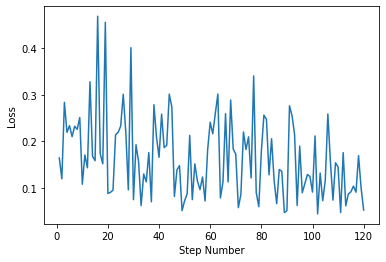

In [104]:
model = RCNN(vocab_size=30000,
            embedding_dim=500,
            hidden_size=1024,
            hidden_size_linear=1024,
            class_num=4,
            dropout=0.0).to(device)

optimizer1 = torch.optim.Adam(model.parameters(), lr=1e-5)
optimizer2 = torch.optim.Adam(model.parameters(), lr=1e-6)
train(model, optimizer1,optimizer2, train_biased_dataloader, valid_dataloader,10)

In [105]:
test_model = RCNN(vocab_size=30000,
            embedding_dim=500,
            hidden_size=1024,
            hidden_size_linear=1024,
            class_num=4,
            dropout=0.0).to(device)
PATH = './best.pth'
test_model.load_state_dict(torch.load(PATH))
test_file_path = '/content/drive/MyDrive/Colab Notebooks/data_text/test.csv'
test_texts, test_labels = read_file(test_file_path)
test_dataset = CustomTextDataset(test_texts, test_labels, word2idx)
test_dataloader = DataLoader(dataset=test_dataset,
                            collate_fn=lambda x: collate_fn(x, 32),
                            batch_size=32,
                            shuffle=True)

_, accuracy, precision, recall, f1, cm = evaluate(test_model, test_dataloader)
print('-'*50)
print(f'|* TEST SET *| |ACC| {accuracy:>.4f} |PRECISION| {precision:>.4f} |RECALL| {recall:>.4f} |F1| {f1:>.4f}')
print('-'*50)
print('---------------- CONFUSION MATRIX ----------------')
for i in range(len(cm)):
  print(cm[i])
print('--------------------------------------------------')


--------------------------------------------------
|* TEST SET *| |ACC| 88.6842 |PRECISION| 0.8866 |RECALL| 0.8868 |F1| 0.8867
--------------------------------------------------
---------------- CONFUSION MATRIX ----------------
[1695   61   84   60]
[  46 1806   18   30]
[  75   27 1610  188]
[  77   36  158 1629]
--------------------------------------------------


In [106]:
import higher
def train_weighted(model,optimizer1,optimizer2, train_dataloader,validation_dataloader,epochs):
  best_f1 = 0
  loss_val = []
  step_num = []
  loss_val_meta = []
  optimizer2.zero_grad()
  count = 1
  criterion = nn.CrossEntropyLoss().to(device)
  meta_loss = 0
  print('Starting Training!')
  for epoch in range(1, epochs+1):
    model.train()
    for step, (x,y) in enumerate(train_dataloader):
      optimizer1.zero_grad()
      x,y = x.to(device), y.to(device)
      with higher.innerloop_ctx(model,optimizer1) as (meta_model, meta_optimizer):
        with torch.backends.cudnn.flags(enabled=False):
          pred = meta_model(x)
        criterion.reduction = 'none'
        meta_train_loss = criterion(pred,y)
        epsilon = torch.zeros(meta_train_loss.size(),requires_grad=True,device=device)
        meta_train_loss = torch.sum(epsilon*meta_train_loss)
        meta_optimizer.step(meta_train_loss)
        meta_inputs, meta_labels = next(iter(validation_dataloader))
        meta_inputs, meta_labels = meta_inputs.to(device), meta_labels.to(device)
        with torch.backends.cudnn.flags(enabled=False):
          meta_val_pred = meta_model(meta_inputs)
        criterion.reduction = 'mean'
        meta_val_loss = criterion(meta_val_pred,meta_labels)
        epsilon_grad = torch.autograd.grad(meta_val_loss,epsilon)[0].detach()
        meta_loss += meta_val_loss.item()
        
      w_tilde = torch.clamp(-1*epsilon_grad, min=0)
      l1_norm = torch.sum(w_tilde)
      if l1_norm != 0:
        w = w_tilde/l1_norm
      else:
        w = w_tilde
      
      pred_training = model(x)
      criterion.reduction = 'none'
      training_loss_minibatch = criterion(pred_training,y)
      training_loss_minibatch = torch.sum(w*training_loss_minibatch)
      training_loss_minibatch.backward()
      optimizer1.step()
      if(step+1)% 200 == 0:
        print(f'|EPOCHS| {epoch:>}/{epochs} |STEP| {step+1:>4}/{len(train_dataloader)} |LOSS| {training_loss_minibatch.item():>.4f}')
        loss_val.append(training_loss_minibatch.item())
        step_num.append(int(count))
        count += 1
    avg_loss, accuracy, _, _, f1, _ = evaluate(model, valid_dataloader)
    print('-'*50)
    print(f'|* VALID SET *| |VAL LOSS| {avg_loss:>.4f} |ACC| {accuracy:>.4f} |F1| {f1:>.4f}')
    print('-'*50)
    PATH = './best.pth'
    if f1 > best_f1:
      best_f1 = f1
      print(f'Saving best model... F1 score is {best_f1:>.4f}')
      torch.save(model.state_dict(),PATH)
      print('Model saved!')
  plt.plot(step_num,loss_val)
  plt.xlabel("Step Number")
  plt.ylabel("Loss")
  plt.show()

      
      



    
  

Starting Training!
|EPOCHS| 1/10 |STEP|  200/2500 |LOSS| 1.2934
|EPOCHS| 1/10 |STEP|  400/2500 |LOSS| 1.3038
|EPOCHS| 1/10 |STEP|  600/2500 |LOSS| 1.2638
|EPOCHS| 1/10 |STEP|  800/2500 |LOSS| 1.2350
|EPOCHS| 1/10 |STEP| 1000/2500 |LOSS| 1.2183
|EPOCHS| 1/10 |STEP| 1200/2500 |LOSS| 1.1337
|EPOCHS| 1/10 |STEP| 1400/2500 |LOSS| 1.1020
|EPOCHS| 1/10 |STEP| 1600/2500 |LOSS| 0.9396
|EPOCHS| 1/10 |STEP| 1800/2500 |LOSS| 0.7940
|EPOCHS| 1/10 |STEP| 2000/2500 |LOSS| 1.1264
|EPOCHS| 1/10 |STEP| 2200/2500 |LOSS| 0.9193
|EPOCHS| 1/10 |STEP| 2400/2500 |LOSS| 0.5169
--------------------------------------------------
|* VALID SET *| |VAL LOSS| 0.7743 |ACC| 74.4375 |F1| 0.7421
--------------------------------------------------
Saving best model... F1 score is 0.7421
Model saved!
|EPOCHS| 2/10 |STEP|  200/2500 |LOSS| 1.1125
|EPOCHS| 2/10 |STEP|  400/2500 |LOSS| 1.1567
|EPOCHS| 2/10 |STEP|  600/2500 |LOSS| 0.8781
|EPOCHS| 2/10 |STEP|  800/2500 |LOSS| 0.8019
|EPOCHS| 2/10 |STEP| 1000/2500 |LOSS| 0.8206
|

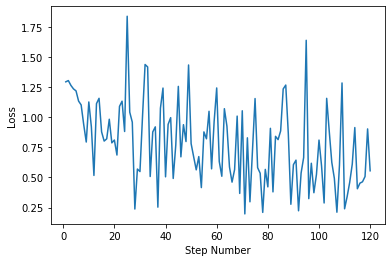

In [108]:
model = RCNN(vocab_size=30000,
            embedding_dim=500,
            hidden_size=1024,
            hidden_size_linear=1024,
            class_num=4,
            dropout=0.0).to(device)

optimizer1 = torch.optim.Adam(model.parameters(), lr=1e-5)
optimizer2 = torch.optim.Adam(model.parameters(), lr=1e-6)
train_weighted(model, optimizer1,optimizer2, train_biased_dataloader, valid_dataloader,10)

In [109]:
test_model = RCNN(vocab_size=30000,
            embedding_dim=500,
            hidden_size=1024,
            hidden_size_linear=1024,
            class_num=4,
            dropout=0.0).to(device)
PATH = './best.pth'
test_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [110]:
test_file_path = '/content/drive/MyDrive/Colab Notebooks/data_text/test.csv'
test_texts, test_labels = read_file(test_file_path)
test_dataset = CustomTextDataset(test_texts, test_labels, word2idx)
test_dataloader = DataLoader(dataset=test_dataset,
                            collate_fn=lambda x: collate_fn(x, 32),
                            batch_size=32,
                            shuffle=True)

_, accuracy, precision, recall, f1, cm = evaluate(test_model, test_dataloader)
print('-'*50)
print(f'|* TEST SET *| |ACC| {accuracy:>.4f} |PRECISION| {precision:>.4f} |RECALL| {recall:>.4f} |F1| {f1:>.4f}')
print('-'*50)
print('---------------- CONFUSION MATRIX ----------------')
for i in range(len(cm)):
  print(cm[i])
print('--------------------------------------------------')


--------------------------------------------------
|* TEST SET *| |ACC| 87.7500 |PRECISION| 0.8774 |RECALL| 0.8775 |F1| 0.8773
--------------------------------------------------
---------------- CONFUSION MATRIX ----------------
[1719   59   78   44]
[  69 1779   26   26]
[  89   23 1593  195]
[ 107   34  181 1578]
--------------------------------------------------
